In [45]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [46]:
def parse_matrix(matrix_str):
    # Remove the square brackets and any leading/trailing whitespace
    matrix_str = matrix_str.strip().strip('[]')

    # Split the string into rows using the semicolon
    rows = matrix_str.split(';')

    matrix = []
    for row in rows:
        # Split each row into elements based on spaces or commas
        elements = re.split(r'\s+', row.strip())
        # Convert elements to float (modify if data types differ)
        row_data = [float(elem) for elem in elements if elem]
        matrix.append(row_data)
    return matrix

In [47]:
def read_data(file_path):
    # List to hold all parsed matrices
    matrices = []

    with open(file_path, 'r') as file:
        for line_num, line in enumerate(file, start=1):
            try:
                matrix = parse_matrix(line)
                matrices.append(matrix)
            except Exception as e:
                print(f"Error parsing line {line_num}: {e}")
                
    # Convert the list of matrices to a NumPy array
    # Shape will be (number_of_matrices, rows, cols)
    matrices_array = np.array(matrices)
    
    # Number of matrices, rows, and columns
    num_matrices, rows, cols = matrices_array.shape

    # Flatten each matrix
    flattened = matrices_array.reshape(num_matrices, rows * cols)

    # Generate column names, e.g., 'row1_col1', 'row1_col2', etc.
    columns = [f'row{r+1}_col{c+1}' for r in range(rows) for c in range(cols)]

    # Create the DataFrame
    df = pd.DataFrame(flattened, columns=columns)
    
    print(f"{file_path} array shape: {df.shape}")
    
    return df
    
X_train = read_data('PEMS_train')
y_train = read_data('PEMS_trainlabels')

X_test = read_data('PEMS_test')
y_test = read_data('PEMS_testlabels')

PEMS_train array shape: (267, 138672)
PEMS_trainlabels array shape: (1, 267)
PEMS_test array shape: (173, 138672)
PEMS_testlabels array shape: (1, 173)


In [48]:
y_train = y_train.T
y_test = y_test.T

,0
row1_col1,3.0
row1_col2,4.0
row1_col3,3.0
row1_col4,5.0
row1_col5,1.0


In [49]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data while avoiding data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

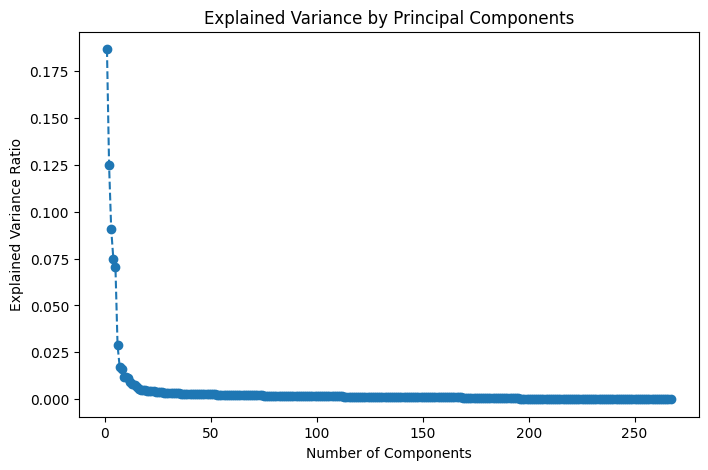

In [50]:
# Initialize PCA without specifying the number of components to get all components
pca = PCA()

# Fit PCA on the scaled data
pca.fit(X_train_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

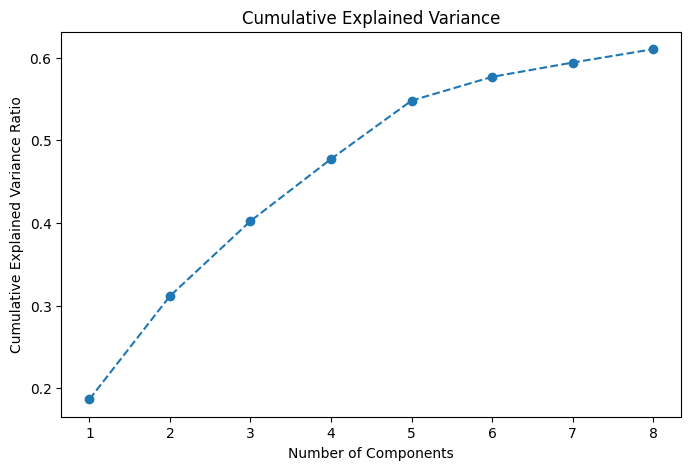

Number of components selected: 8


In [51]:
n_components = 0.6  # Minimum number of components to explain 98% variance
pca = PCA(n_components=n_components)

# Choose the number of components (e.g., enough to explain 98% variance)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

# Principal components selected
print(f"Number of components selected: {pca.n_components_}")

In [52]:
X_train_reduced = pd.DataFrame(X_train_pca)
X_test_reduced = pd.DataFrame(X_test_pca)

In [53]:
X_train_reduced.head()

,0,1,2,3,4,5,6,7
0,-125.309989,102.515025,55.519164,-100.038141,-54.083465,-72.640313,9.933070,7.768484
1,-129.802996,101.995014,55.763515,-104.557521,-55.031676,-54.017625,10.972741,2.780318
2,-129.730477,82.015655,54.897932,-94.785650,-49.262239,-38.595172,20.127843,7.640389
3,-92.094065,109.775080,103.095854,161.199478,110.654366,-2.518126,14.608049,-3.077926
4,-86.929717,-225.875017,44.144652,144.435385,61.514495,-37.517748,-47.879870,-1.742879


In [54]:
y_test = y_test.convert_dtypes(int)
y_train = y_train.convert_dtypes(int)

In [55]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Fit the models
rf_model = rf.fit(X_train_reduced, y_train)
rf_model.score(X_test_reduced, y_test) 

c:\Users\de130063\AppData\Local\anaconda3\envs\DHBW-AAML\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.8901734104046243

In [56]:
gb.fit(X_train_reduced, y_train)
gb.score(X_test_reduced, y_test)

c:\Users\de130063\AppData\Local\anaconda3\envs\DHBW-AAML\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9017341040462428

- 30% vairance, 2 components, 79.77% accuracy
- 60% vairance, 9 components, 91.3% accuracy
- 80% vairance, 52 components, 87.28% accuracy
- 100% variance, 267 components, 90.7% accuracy

In [57]:
# XGB boost needs the labels to start from 0
y_train[0] = y_train[0] - 1
y_test[0] = y_test[0] - 1

In [58]:
xgb.fit(X_train_reduced, y_train)
xgb.score(X_test_reduced, y_test)

0.9075144508670521

- 30% vairance, 2 components, 79.2% accuracy
- 60% vairance, 9 components, 90.17% accuracy
- 80% vairance, 52 components, 86.7% accuracy
- 100% variance, 267 components, 85.5% accuracy